# [E-07]PortraitMode

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(868, 750, 3)


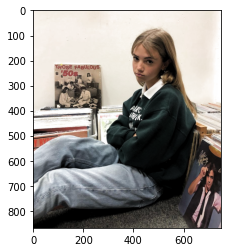

In [4]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image.PNG'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션(Segmentation)
* 이미지 세그멘테이션(image segmentation) : 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법
* 시맨틱 세그멘테이션(semantic segmentation) : 물리적 의미 단위로 인식하는 세그멘테이션(이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류하는 방법)
* 인스턴스 세그멘테이션(instance segmentation) : 사람 개개인별로 다른 라벨을 가지게 한다. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표

In [5]:
# 저장할 파일 이름을 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xceptation_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xceptation_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7faa682633d0>)

In [6]:
# PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [8]:
# 모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)   # PASCALVOC 데이터로 학습된 모델을 이용한다

In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

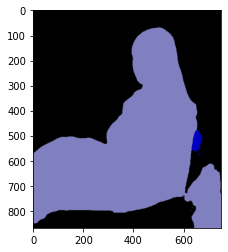

In [10]:
plt.imshow(output)   # output에 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있다
plt.show()

In [11]:
segvalues   # class_ids 와 masks 포함

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [13]:
for class_id in segvalues['class_ids']:   # class_ids 를 통해 어떤 물체가 담겨 있는지 알 수 있다
    print(LABEL_NAMES[class_id])

background
chair
person


In [14]:
# PixelLib에서 그대로 가져온 코드
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

# output 이미지가 BGR 순서로 채널 배치가 되어 있다
# colormap 은 RGB 순서
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [15]:
colormap[15]   # 사람을 나타내는 15번째 색상

array([192, 128, 128])

In [17]:
# 색상 값 순서 변환 
seg_color = (128,128,192)

(868, 750)


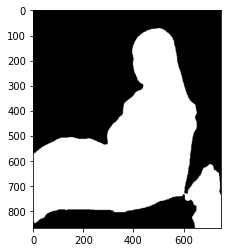

In [18]:
# seg_color 로만 이루어진 마스크 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

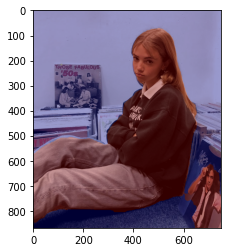

In [19]:
# 원래 이미지와 겹쳐서 확인해보기

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

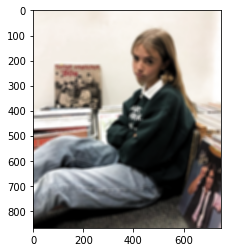

In [25]:
# 배경을 흐리게 만들기
# (13,13)은 blurring kernel size
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

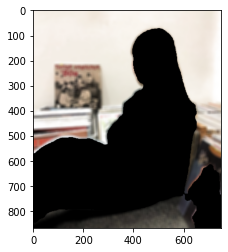

In [22]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)   # bitwise_not : 이미지 반전 (배경 255, 사람 0)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)   # bitwise_and : 배경만 있는 영상을 얻을 수 있다
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

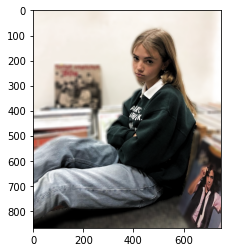

In [23]:
# 배경과 사람 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점
중심인물 옆에 있는 LP 커버 사진에 있는 사람은 배경에 포함되지 않았다.

### 해결 방법 생각해보기
인물간에 라벨을 부여하고 불필요한 라벨을 제외하면 될 거 같았다.
다른 사람이 만들어 둔 새로운 모델을 사용하려던 중에 오류가 생겨 중단했다.

### 느낀점
이미지 세그멘테이션을 위한 다양한 모델이 있다는 것을 알게되었다.  
또한 가우시안 블러 등 다양한 효과를 더할 수 있다는 것도 알게되었다.  
노드에서 소개한 모델이 사람 형상을 생각보다 잘 찾아내서 놀랐다.  
좀 더 공부해서 더 정확하개 원하는 것을 구현해내고싶다.